In [52]:
from river import stream,tree,metrics
import utils
import datetime
from encoding import prefix_bin
import csv

In [53]:
dataset = stream.iter_csv(
            './data/bpic2017.csv',
            drop=['(case) Accepted', '(case) ApplicationID', '(case) CreditScore', '(case) FirstWithdrawalAmount',
            '(case) MonthlyCost', '(case) NumberOfTerms', '(case) OfferedAmount', '(case) Selected',
            'Action', 'EventID', 'EventOrigin', 'OfferID', 'lifecycle:transition']
            )
totallength = len(list(dataset))

In [54]:
dataset = stream.iter_csv(
            './data/bpic2017.csv',
            drop=['(case) Accepted', '(case) ApplicationID', '(case) CreditScore', '(case) FirstWithdrawalAmount',
            '(case) MonthlyCost', '(case) NumberOfTerms', '(case) OfferedAmount', '(case) Selected',
            'Action', 'EventID', 'EventOrigin', 'OfferID', 'lifecycle:transition']
            )

In [55]:
key_pair = {
    'Case ID' : 'caseid',
    'Activity' : 'activity',
    'Resource' : 'resource',
    'Complete Timestamp' : 'ts'
}

case_dict ={}
trainset_prefix ={}
feature_matrix ={}
casecount = 0
rowcounter = 0
resultdict ={}

acc_dict ={}

In [56]:
for x,y in dataset:
    if rowcounter%1000 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)

    # Event timestamp slice decimals
    x['ts'] = x['ts'][:-4]

    # Check label possible
    x = utils.set_label(x)

    # Initialize case by prefix length
    caseid = x['caseid']
    x.pop('caseid')
    case_bin = prefix_bin(caseid, x)

    # Allocate event stream to prefix bin class
    if 'True label' not in x.keys():
        if caseid not in list(case_dict.keys()):
            case_bin.set_prefix_length(1)    
            case_dict[caseid] = []
        else:
            case_bin.set_prefix_length(len(case_dict[caseid])+1)
            case_bin.set_prev_enc(case_dict[caseid][-1])
        case_bin.update_encoded()
        case_dict[caseid].append(case_bin)

    # Adding newly finished case to training set.    
    else:
        casecount +=1

        # Grace period to collect feature matrix
        if casecount <100:
            case_length = len(case_dict[caseid])
            for prefix in range(1, case_length):
                if 'prefix_%s'%(prefix+1) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(prefix+1)]=set()
                    # Initialize classifier and performance matrix and updating count
                    trainset_prefix['prefix_%s'%(prefix+1)] = [tree.HoeffdingTreeClassifier(),metrics.Accuracy(), 0]
                feature_list = list(case_dict[caseid][prefix].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(prefix+1)].add(x) 
            case_dict.pop(caseid)               

        # Real training start
        else:
            # Modify encoded attributes of cases with feature matrix
            case_length = len(case_dict[caseid])
            y = x['True label']
            for prefix in range(1, case_length):
                if case_dict[caseid][prefix].grace_updated == False:
                    case_dict[caseid][prefix].encoded = utils.readjustment_training(case_dict[caseid][prefix].encoded, feature_matrix['prefix_%s'%(prefix+1)])
                case_dict[caseid][prefix].update_grace_status(True)
                x = case_dict[caseid][prefix].encoded
                model = trainset_prefix['prefix_%s'%(prefix+1)][0]
                model.learn_one(x,y)
                trainset_prefix['prefix_%s'%(prefix+1)][2] +=1
                y_pred = model.predict_one(x)
                trainset_prefix['prefix_%s'%(prefix+1)][1].update(y,y_pred)

                for cases in list(case_dict.keys()):
                    if len(case_dict[cases]) >prefix:
                        if case_dict[cases][prefix].grace_updated ==False:
                            case_dict[cases][prefix].encoded = utils.readjustment_training(case_dict[cases][prefix].encoded, feature_matrix['prefix_%s'%(prefix+1)])

                        case_dict[cases][prefix].update_grace_status(True)
                        x_test = case_dict[cases][prefix].encoded
                        y_pred = model.predict_one(x_test)
                        case_dict[cases][prefix].update_prediction((trainset_prefix['prefix_%s'%(prefix+1)][2], y_pred))
            resultdict[caseid] = case_dict.pop(caseid)

    if casecount > 200 and rowcounter%1000 == 0:
        for prefix in trainset_prefix.keys():
            model = trainset_prefix[prefix][0]
            if prefix not in list(acc_dict.keys()):
                acc_dict[prefix]=[trainset_prefix[prefix][1].get()]
            else:
                acc_dict[prefix].append(trainset_prefix[prefix][1].get())
            outputfile = './%s/%s.png'%(prefix, round(rowcounter*100/totallength,2))
            utils.save_graph_as_png(model.draw(),outputfile)


0.0 % Case finished: 0
4.46 % Case finished: 22
8.92 % Case finished: 47
13.39 % Case finished: 110
17.85 % Case finished: 244
22.31 % Case finished: 362
26.77 % Case finished: 503
31.24 % Case finished: 686
35.7 % Case finished: 820
40.16 % Case finished: 974
44.62 % Case finished: 1008
49.09 % Case finished: 1081
53.55 % Case finished: 1203
58.01 % Case finished: 1373
62.47 % Case finished: 1584
66.94 % Case finished: 1744
71.4 % Case finished: 1910
75.86 % Case finished: 2132
80.32 % Case finished: 2273
84.79 % Case finished: 2469
89.25 % Case finished: 2953
93.71 % Case finished: 3711
98.17 % Case finished: 4599


In [57]:
for prefix in acc_dict.keys():
    print(acc_dict[prefix])

[0.6, 0.5855513307984791, 0.5742574257425742, 0.5996592844974447, 0.5936199722607489, 0.584, 0.5863586358635864, 0.5733197556008147, 0.5597826086956522, 0.5408163265306123, 0.5306397306397307, 0.5124620060790274, 0.5107675317504141, 0.49483521888834237, 0.484360625574977, 0.47890295358649787, 0.4744218640504555, 0.4584717607973422, 0.4915555555555556]
[0.635036496350365, 0.6209677419354839, 0.6057441253263708, 0.6281138790035588, 0.6286549707602339, 0.6136363636363636, 0.6149425287356322, 0.6017039403620873, 0.5880681818181818, 0.5667485667485668, 0.5558678847505271, 0.5364616360177552, 0.5345622119815668, 0.5171706817016914, 0.5047846889952153, 0.49890302764370337, 0.4914824211670895, 0.4723646723646724, 0.40597219056302714]
[0.875, 0.8359788359788359, 0.8054607508532423, 0.8206896551724138, 0.8169811320754717, 0.8037383177570093, 0.804185351270553, 0.8011283497884344, 0.7936305732484077, 0.7815315315315315, 0.7812807881773399, 0.7808471454880295, 0.7769423558897243, 0.770579268292683

In [58]:
import matplotlib.pyplot as plt

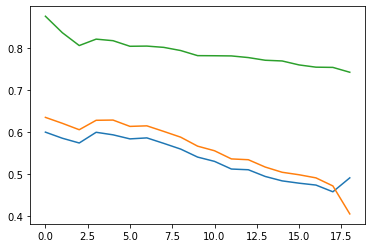

In [61]:
for prefix in acc_dict.keys():
    plt.plot(range(len(acc_dict[prefix])), acc_dict[prefix])